In [106]:
import yfinance as yf

#trained on Nvidea daily data ,Nvidea minute wise data,ITCL,AAPL,DJTWW,GOOGLE

nvda = yf.Ticker("GOOG")
datas = nvda.history(period="5d", interval="1m")


print(datas)


datas.to_csv("GOOG_1m_data.csv")

                                 Open        High         Low       Close  \
Datetime                                                                    
2025-01-06 09:30:00-05:00  195.149994  196.800003  195.059998  196.720001   
2025-01-06 09:31:00-05:00  196.619995  196.830002  196.179993  196.205002   
2025-01-06 09:32:00-05:00  196.134995  196.600006  195.854996  196.130005   
2025-01-06 09:33:00-05:00  196.100006  197.100006  196.009995  196.875000   
2025-01-06 09:34:00-05:00  196.895004  197.520004  196.895004  197.410004   
...                               ...         ...         ...         ...   
2025-01-13 15:55:00-05:00  192.119995  192.449997  192.089996  192.399994   
2025-01-13 15:56:00-05:00  192.389999  192.419998  192.315994  192.354996   
2025-01-13 15:57:00-05:00  192.360001  192.399994  192.220001  192.389999   
2025-01-13 15:58:00-05:00  192.380005  192.490005  192.380005  192.449997   
2025-01-13 15:59:00-05:00  192.442001  192.455002  192.199997  192.279999   

In [107]:
data = datas.dropna()
data=data.drop(["Dividends","Stock Splits"], axis=1)
import pandas as pd
from sklearn.preprocessing import MinMaxScaler



scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)
data = pd.DataFrame(data_normalized, columns=data.columns)
train_size = int(len(data) * 0.75)
train_data = data[:train_size]
test_data = data[train_size:]

In [108]:
from stable_baselines3 import PPO

import gym

# Define the trading environment
class TradingEnvironment(gym.Env):
    def __init__(self, data):
        self.data = data
        self.action_space = gym.spaces.Discrete(3)  # Buy, Sell, Hold
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(data.columns),))

    def reset(self):
        self.current_step = 0
        self.account_balance =500 # Initial account balance
        self.shares_held = 0
        self.net_worth = self.account_balance
        self.max_net_worth = self.account_balance

        return self._next_observation()

    def _next_observation(self):
        return self.data.iloc[self.current_step].values

    def step(self, action):
        self._take_action(action)
        self.current_step += 1

        # Ensure we don't exceed the data length
        if self.current_step >= len(self.data):
            done = True
            self.current_step = 0  # Restart the episode
        else:
            done = False

        return self._next_observation(), self._get_reward(), done, {}

    def _take_action(self, action):
        current_price = self.data.iloc[self.current_step].values[0]

        if action == 0:  # Buy
            # Ensure you only buy if you have enough balance

            if self.account_balance > current_price:
                self.shares_held += self.account_balance / current_price
                self.account_balance = 0  # Spend all the balance
        elif action == 1:  # Sell
            if self.shares_held > 0:
                self.account_balance += self.shares_held * current_price
                self.shares_held = 0  # Sell all shares

        # Calculate the net worth after the action

        self.net_worth = self.account_balance + self.shares_held * current_price


        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

    def _get_reward(self):

        return self.net_worth - (self.account_balance + self.shares_held * self.data.iloc[self.current_step].values[0])
# Create the trading environment
env = TradingEnvironment(train_data)

In [109]:
from stable_baselines3 import DDPG, A2C, DQN

model = DQN.load("model", env=env, verbose=1)
model.set_env(env)



model.learn(total_timesteps=10000,log_interval=1)


J:\Projects\DLproject\ModelTesting\DeepReinforcmentLearning\.venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.46e+03 |
|    ep_rew_mean      | 274      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1        |
|    fps              | 996      |
|    time_elapsed     | 1        |
|    total_timesteps  | 1460     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | nan      |
|    n_updates        | 262689   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.46e+03 |
|    ep_rew_mean      | 185      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2        |
|    fps              | 988      |
|    time_elapsed     | 2        |
|    t

In [110]:
import numpy as np
def evaluate_model(model, env, num_episodes=10):
    total_rewards = []

    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward

        total_rewards.append(total_reward)

    avg_total_reward = np.mean(total_rewards)
    print(f"Average total reward over {num_episodes} episodes: {avg_total_reward}")
def simulate_trading_strategy(model, data):
    env = TradingEnvironment(data)
    obs = env.reset()

    # Initialize a list to store net worth at each time step
    net_worth_history = [env.net_worth]

    for _ in range(len(data) - 1):  # Adjust loop to avoid exceeding data length
        action, _ = model.predict(obs)
        obs, _, done, _ = env.step(action)

        # Append the current net worth to the history
        net_worth_history.append(env.net_worth)

        # Check if done flag is reached
        if done:
            print("Reached the end of the dataset.")
            break

    return net_worth_history




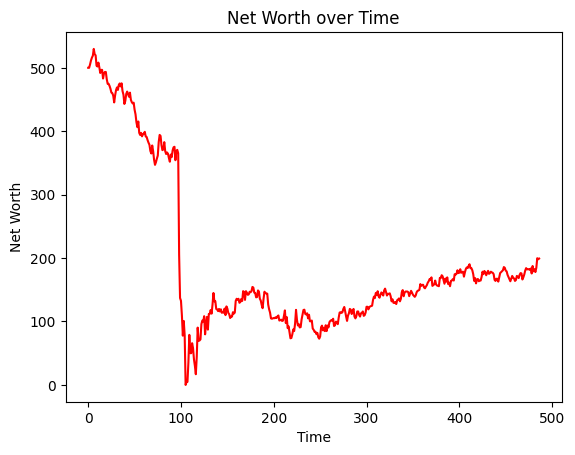

In [111]:
net_worth = simulate_trading_strategy(model, test_data)
import matplotlib.pyplot as plt


# Plot the net worth over time
plt.plot(net_worth,color='red')
plt.xlabel("Time")
plt.ylabel("Net Worth")
plt.title("Net Worth over Time")
plt.show()


In [113]:
def evaluate_model(model, env, num_episodes=10):
    total_rewards = []

    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward

        total_rewards.append(total_reward)

    avg_total_reward = np.mean(total_rewards)
    print(f"Average total reward over {num_episodes} episodes: {avg_total_reward}")

test_env = TradingEnvironment(test_data)
evaluate_model(model, test_env)

Average total reward over 10 episodes: 52.49216190331667


In [115]:
model.save("model")